## Matching Exercise

### Nick Carroll & Yuanjing Zhu

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import altair as alt
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

In [94]:
cps = pd.read_stata(
    "https://github.com/nickeubank/MIDS_Data/blob/master"
    "/Current_Population_Survey/cps_for_matching.dta?raw=true"
)

In [95]:
cps.head()

,index,annual_earnings,female,simplified_race,has_college,age,county,class94
0,151404,NaN,1,3.0,1,30,0-WV,"Private, For Profit"
1,123453,NaN,0,0.0,0,21,251-TX,"Private, For Profit"
2,187982,NaN,0,0.0,0,40,5-MA,"Self-Employed, Unincorporated"
3,122356,NaN,1,0.0,1,27,0-TN,"Private, Nonprofit"
4,210750,42900.0,1,0.0,0,52,0-IA,"Private, For Profit"


## Exercise 1: raw difference of annual_earnings between those with and without a college degree

In [96]:
annual_earnings_with_college = cps.loc[cps['has_college']==1, 'annual_earnings']
annual_earnings_without_college = cps.loc[cps['has_college']==0, 'annual_earnings']

raw_diff = annual_earnings_with_college.mean() - annual_earnings_without_college.mean()
print(f'The raw difference of annual_earnings between those with and without a college degree is ${raw_diff:.2f}')

The raw difference of annual_earnings between those with and without a college degree is $14158.50


In [97]:
_, pvalue = stats.ttest_ind(annual_earnings_with_college, annual_earnings_without_college, nan_policy='omit')
print(f'The p-value for the t-test is {pvalue:.2f}')

The p-value for the t-test is 0.00


The difference is statistically significant

## Exercise 2: check for balance

- **Race**

In [98]:
cps['simplified_race'].value_counts()

0.0    7622
2.0    1512
1.0    1020
3.0     996
Name: simplified_race, dtype: int64

Race is coded as White Non-Hispanic (0), Black Non-Hispanic (1), Hispanic (2), Other (3).

In [99]:
college_by_race = cps.groupby("simplified_race")["has_college"].mean()

print("Share of people in different racial groups who have college degrees:")
print(college_by_race)

Share of people in different racial groups who have college degrees:
simplified_race
0.0    0.438205
1.0    0.317647
2.0    0.198413
3.0    0.474900
Name: has_college, dtype: float64


In [100]:
cross_tab = pd.crosstab(cps['simplified_race'], cps['has_college'])
_, p, _, _ = stats.chi2_contingency(cross_tab)
print(f"P-value for chi-square test: {p:.2f}")

P-value for chi-square test: 0.00


Those difference in the share of people in different racial groups who have college degrees is statistically significant

- **County**

In [101]:
cps.groupby('county')['has_college'].mean()

county
0-AK     0.323308
0-AL     0.337143
0-AR     0.298246
0-AZ     0.714286
0-CA     0.395455
           ...   
97-IL    0.520000
99-CA    0.133333
99-FL    0.583333
99-MI    0.476190
99-MO    0.333333
Name: has_college, Length: 326, dtype: float64

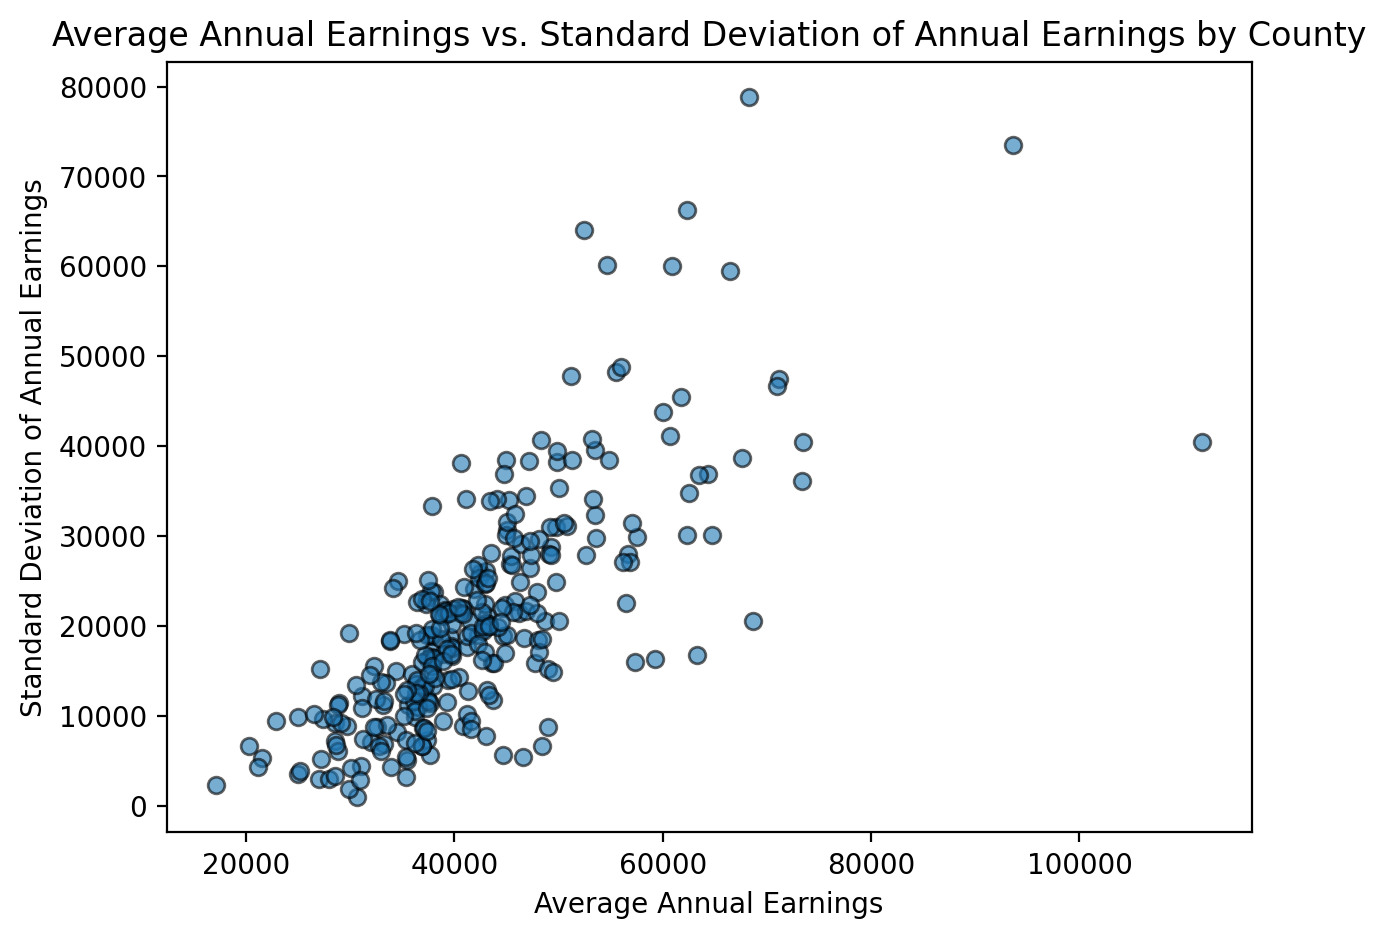

In [102]:
# plot the difference 
l_avg = []
l_std = []
for i in cps['county'].unique():
    l_avg.append(cps.loc[cps['county']==i, 'annual_earnings'].mean())
    l_std.append(cps.loc[cps['county']==i, 'annual_earnings'].std())

plt.figure(figsize=(7,5), dpi=100)
plt.scatter(l_avg, l_std, edgecolors='black', alpha=0.6)
plt.xlabel('Average Annual Earnings')
plt.ylabel('Standard Deviation of Annual Earnings')
plt.title('Average Annual Earnings vs. Standard Deviation of Annual Earnings by County')
plt.show()

The distribution the share of people who have college degrees looks different across counties

In terms of race and county, the data seems to be imbalanced.

### Exercise 3: Plot a non-linear regression of annual_earnings on age

In [103]:
alt.data_transformers.disable_max_rows()
alt.renderers.set_embed_options(width=600, height=400)
base = (
    alt.Chart(cps).mark_point().encode(
        x = alt.X('age', title='Age', scale=alt.Scale(zero=False)),
        y = alt.Y('annual_earnings',title='Annual Earnings', scale=alt.Scale(zero=False)),
    )
)
# change font size
base.configure_title(fontSize=20)

# fit a regression line
loess = base.transform_loess(
    'age', 'annual_earnings').mark_line(color='red')

base + loess


alt.LayerChart(...)

- The relationship between age and annual earnings looks non-linear.

Does this speak to why it’s nice to not have to think about functional forms with matching as much?

### Exercise 4: Create a new variable that discretizes age into a single value for each decade of age.

In [104]:
print(f"Age range: {cps['age'].min()} to {cps['age'].max()}")

Age range: 16 to 85


In [105]:
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90]
pd.cut(cps['age'], bins=bins).value_counts().sort_index()

(0, 20]      214
(20, 30]    2047
(30, 40]    2737
(40, 50]    2582
(50, 60]    2315
(60, 70]    1082
(70, 80]     156
(80, 90]      17
Name: age, dtype: int64

Create a new variable that discretizes age:
- 0-30: 0
- 31-40: 1
- 41-50: 2
- 51-60: 3
- 61-70: 4
- 71-90: 5

In [106]:
# create a new varibalbe that discretizes age into 7 bins
cps.loc[cps['age'] < 30, 'age_group'] = 0
cps.loc[(cps['age'] >= 30) & (cps['age'] < 40), 'age_group'] = 1
cps.loc[(cps['age'] >= 40) & (cps['age'] < 50), 'age_group'] = 2
cps.loc[(cps['age'] >= 50) & (cps['age'] < 60), 'age_group'] = 3
cps.loc[(cps['age'] >= 60) & (cps['age'] < 70), 'age_group'] = 4
cps.loc[cps['age'] >= 70, 'age_group'] = 5
cps['age_group'] = cps['age_group'].astype("category")

### Exercise 5: covert our string variables into numeric variables for DAME

In [107]:
# convert county and class94 to a numeric vector of intergers using pd.Categorical
cps['county'] = pd.Categorical(cps['county']).codes
cps['class94'] = pd.Categorical(cps['class94']).codes

### Exercise 6: drop all the variables we don’t need

In [108]:
# drop the original variables that we dont need 
cps_2 = cps.copy()   # create a copy of the dataframe
cps_2.drop(columns=['age', 'index'], inplace=True)
cps_2.dropna(inplace=True)
cps_2.reset_index(inplace=True, drop=True)
cps_2.head()

,annual_earnings,female,simplified_race,has_college,county,class94,age_group
0,42900.0,1,0.0,0,10,3,3.0
1,31200.0,0,2.0,0,31,3,1.0
2,20020.0,0,0.0,1,8,3,4.0
3,22859.2,0,0.0,0,44,1,2.0
4,73860.8,0,0.0,1,24,3,1.0


### Exercise 7: Start matching

In [109]:
import dame_flame
model = dame_flame.matching.DAME(repeats=False, verbose=3, want_pe=True)
model.fit(
    cps_2,
    treatment_column_name="has_college",
    outcome_column_name="annual_earnings",
)
result = model.predict(cps_2)

Completed iteration 0 of matching
	Number of matched groups formed in total:  370
	Unmatched treated units:  644 out of a total of  1150 treated units
	Unmatched control units:  3187 out of a total of  4365 control units
	Number of matches made this iteration:  1684
	Number of matches made so far:  1684
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  1199312680.0957854
Completed iteration 1 of matching
	Number of matched groups formed in total:  494
	Unmatched treated units:  25 out of a total of  1150 treated units
	Unmatched control units:  180 out of a total of  4365 control units
	Number of matches made this iteration:  3626
	Number of matches made so far:  5310
	Covariates dropped so far:  frozenset({'county'})
	Predictive error of covariate set used to match:  1199421883.1095908
Completed iteration 2 of matching
	Number of matched groups formed in total:  494
	Unmatched treated units:  25 out of a total of  1150 treated units
	Unmatched contr

### Exercise 8: plot predicted errors in each iteration

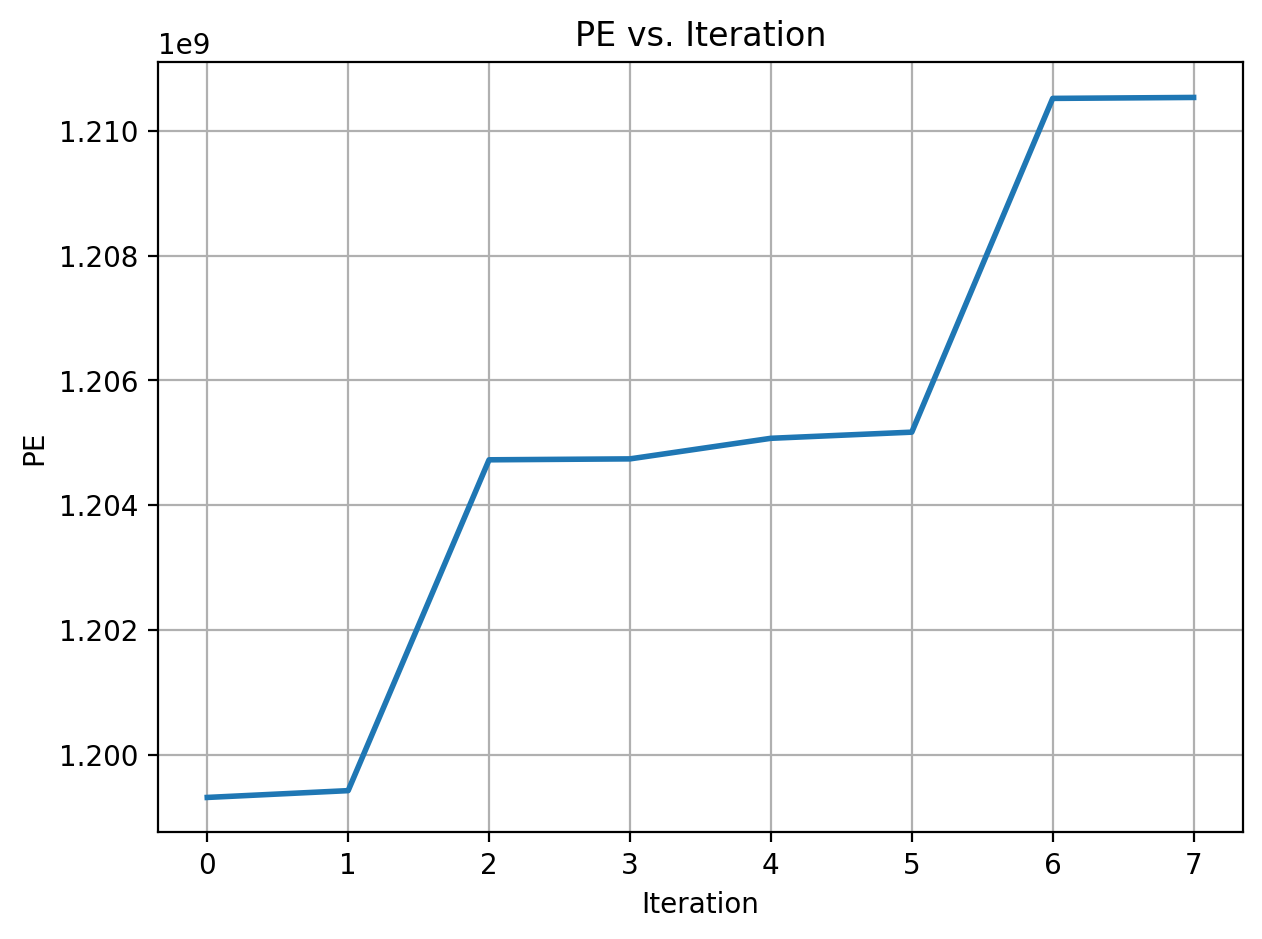

In [110]:
# plot pe vs. iteration
plt.figure(figsize=(7,5), dpi=100)
plt.plot(model.pe_each_iter, linewidth=2)
plt.grid('on')
plt.xlabel('Iteration')
plt.ylabel('PE')
plt.title('PE vs. Iteration')
plt.show()


From iteration 1 to iteration 2, and iteration 5 to iteration6, the matching quality seems to fall off dramatically.

### Exercise 9: where to cut off the data?

In completed iteration 1 of matching, number of matches made so far is 5310, which is larger than 5000. In addtion, the match quality drops dramatically from iteration 1 to iteration 2. Therefore, we might **stop at iteration 1**.

### Exercise 10: rerun matching using early_stop_iterations

In [111]:
model_2 = dame_flame.matching.DAME(repeats=False, verbose=3, want_pe=True, early_stop_iterations=1)
model_2.fit(
    cps_2,
    treatment_column_name="has_college",
    outcome_column_name="annual_earnings",
)
result_2 = model_2.predict(cps_2)

Completed iteration 0 of matching
	Number of matched groups formed in total:  370
	Unmatched treated units:  644 out of a total of  1150 treated units
	Unmatched control units:  3187 out of a total of  4365 control units
	Number of matches made this iteration:  1684
	Number of matches made so far:  1684
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  1199312680.0957854
Completed iteration 1 of matching
	Number of matched groups formed in total:  494
	Unmatched treated units:  25 out of a total of  1150 treated units
	Unmatched control units:  180 out of a total of  4365 control units
	Number of matches made this iteration:  3626
	Number of matches made so far:  5310
	Covariates dropped so far:  frozenset({'county'})
	Predictive error of covariate set used to match:  1199421883.1095908
5310 units matched. We stopped after iteration 1


### Exercise 11: get back dataset

In [112]:
def get_dataframe(model, result_of_fit):
    
    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

In [113]:
matched_data = get_dataframe(model_2, result_2)
matched_data.head()

,annual_earnings,female,simplified_race,has_college,county,class94,age_group,match_group,match_group_size,weights
0,42900.0,1,0.0,0,10,3,3.0,315.0,5.0,0.930000
1,31200.0,0,2.0,0,31,3,1.0,411.0,108.0,0.070189
2,20020.0,0,0.0,1,8,3,4.0,325.0,3.0,1.000000
3,22859.2,0,0.0,0,44,1,2.0,424.0,28.0,1.240000
4,73860.8,0,0.0,1,24,3,1.0,262.0,7.0,1.000000


### Exercise 12: check balance again

In [114]:
import statsmodels.formula.api as smf 

In [115]:
smf.wls(
    "has_college ~ C(simplified_race)", matched_data, weights=matched_data["weights"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:            has_college   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                     0.000
Date:                Tue, 28 Feb 2023   Prob (F-statistic):               1.00
Time:                        21:13:29   Log-Likelihood:                -3736.0
No. Observations:                5310   AIC:                             7480.
Df Residuals:                    5306   BIC:                             7506.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2119      0.007     31.608      0.000       0.199       0.225
C(simplified_race)[T.1.0]  1.665e-16      0.018   9.19e-15      1.000      -0.036       0.036
C(simplified_race)[T.2.0] -8.066e-17      0.019  -4.29e-15      1.000      -0.037       0.037
C(simplified_race)[T.3.0]   3.99e-17      0.020   1.97e-15      1.000      -0.040       0.040
==============================================================================
Omnibus:                      860.389   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1353.227
Skew:                           1.234   Prob(JB):                    1.41e-294
Kurtosis:                       2.851   Cond. No.                         3.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [116]:
smf.wls(
    "annual_earnings ~ C(county)", matched_data, weights=matched_data["weights"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        annual_earnings   R-squared:                       0.097
Model:                            WLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.704
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           8.82e-13
Time:                        21:13:40   Log-Likelihood:                -61639.
No. Observations:                5310   AIC:                         1.239e+05
Df Residuals:                    4994   BIC:                         1.260e+05
Df Model:                         315                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5.244e+04   2507.026     20.916      0.000    4.75e+04    5.74e+04
C(county)[T.1]   -1.189e+04   3488.641     -3.408      0.001   -1.87e+04   -5049.610
C(county)[T.2]   -1.469e+04   3503.012     -4.195      0.000   -2.16e+04   -7826.209
C(county)[T.3]    1304.5895   1.28e+04      0.102      0.919   -2.39e+04    2.65e+04
C(county)[T.4]   -8760.4917   3219.364     -2.721      0.007   -1.51e+04   -2449.124
C(county)[T.5]   -6906.6690   4527.680     -1.525      0.127   -1.58e+04    1969.572
C(county)[T.6]   -1.643e+04   1.13e+04     -1.455      0.146   -3.86e+04    5705.827
C(county)[T.7]   -9093.7230   4147.822     -2.192      0.028   -1.72e+04    -962.171
C(county)[T.8]   -1.389e+04   3416.382     -4.066      0.000   -2.06e+04   -7192.779
C(county)[T.9]   -1.361e+04   5569.268     -2.444      0.015   -2.45e+04   -2691.879
C(county)[T.10]  -1.579e+04   3708.085     -4.258      0.000   -2.31e+04   -8520.931
C(county)[T.11]  -1.251e+04   3283.832     -3.808      0.000   -1.89e+04   -6068.288
C(county)[T.12]  -6481.0973   3380.473     -1.917      0.055   -1.31e+04     146.113
C(county)[T.13]  -1.372e+04   3642.260     -3.766      0.000   -2.09e+04   -6576.261
C(county)[T.14]  -1.542e+04   4244.139     -3.632      0.000   -2.37e+04   -7095.967
C(county)[T.15]  -9856.6109   5203.410     -1.894      0.058   -2.01e+04     344.359
C(county)[T.16]  -1.122e+04   3907.170     -2.870      0.004   -1.89e+04   -3555.611
C(county)[T.17]  -1.357e+04   8393.133     -1.617      0.106      -3e+04    2881.894
C(county)[T.18]  -1503.2836   5153.599     -0.292      0.771   -1.16e+04    8600.034
C(county)[T.19]  -1.474e+04   7114.322     -2.072      0.038   -2.87e+04    -793.047
C(county)[T.20]  -1.172e+04   4693.457     -2.497      0.013   -2.09e+04   -2517.918
C(county)[T.21]  -3219.1965   3877.316     -0.830      0.406   -1.08e+04    4382.045
C(county)[T.22]  -1.743e+04   3993.574     -4.364      0.000   -2.53e+04   -9597.991
C(county)[T.23]  -1.502e+04   3483.642     -4.312      0.000   -2.19e+04   -8192.516
C(county)[T.24]  -9497.6392   3427.725     -2.771      0.006   -1.62e+04   -2777.792
C(county)[T.25]  -1.939e+04   3769.434     -5.143      0.000   -2.68e+04    -1.2e+04
C(county)[T.26]  -1.451e+04   3395.786     -4.273      0.000   -2.12e+04   -7851.875
C(county)[T.27]  -1.306e+04   3618.312     -3.609      0.000   -2.02e+04   -5963.829
C(county)[T.28]  -1.336e+04   6158.954     -2.169      0.030   -2.54e+04   -1282.285
C(county)[T.29]  -6847.5608   5646.561     -1.213      0.225   -1.79e+04    4222.179
C(county)[T.30]  -1078.0211   5467.386     -0.197      0.844   -1.18e+04    9640.457
C(county)[T.31]  -1.271e+04   5112.457     -2.486      0.013   -2.27e+04   -2684.603
C(county)[T.32]  -5644.1071   3936.402     -1.434      0.152   -1.34e+04    2072.969
C(county)[T.33]  -1.166

Coefficients of simplified race are near to 0, and the p-values are 1, indicating it is **not statistically significant**, i.e. **simplified race is balanced**.

### Exercise 13：regress annual earnings on just having a college eduction

In [117]:
smf.wls(
    "annual_earnings ~ has_college", matched_data, weights=matched_data["weights"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        annual_earnings   R-squared:                       0.058
Model:                            WLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     324.1
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           2.19e-70
Time:                        21:14:40   Log-Likelihood:                -61753.
No. Observations:                5310   AIC:                         1.235e+05
Df Residuals:                    5308   BIC:                         1.235e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.909e+04    351.293    111.287      0.000    3.84e+04    3.98e+04
has_college  1.374e+04    763.203     18.003      0.000    1.22e+04    1.52e+04
==============================================================================
Omnibus:                     2934.035   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33100.529
Skew:                           2.424   Prob(JB):                         0.00
Kurtosis:                      14.230   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- The annual earnings of people who has a college degree is $13740 higher than those who don't. 
- It is lower than the initial estimate using the raw CPS data ($14158.50).

### Exercise 14: include other matching variables as controls

In [118]:
matched_data.columns

Index(['annual_earnings', 'female', 'simplified_race', 'has_college', 'county',
       'class94', 'age_group', 'match_group', 'match_group_size', 'weights'],
      dtype='object')

In [119]:
# we dropped county
smf.wls(
    "annual_earnings ~ has_college + female + C(simplified_race) + C(class94) + age_group", \
        matched_data, weights=matched_data["weights"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        annual_earnings   R-squared:                       0.165
Model:                            WLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     74.51
Date:                Tue, 28 Feb 2023   Prob (F-statistic):          1.64e-194
Time:                        21:15:43   Log-Likelihood:                -61433.
No. Observations:                5310   AIC:                         1.229e+05
Df Residuals:                    5295   BIC:                         1.230e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  5.179e+04   1748.995     29.611      0.000    4.84e+04    5.52e+04
C(simplified_race)[T.1.0] -7900.4191    957.233     -8.253      0.000   -9776.990   -6023.848
C(simplified_race)[T.2.0] -3930.8604    995.077     -3.950      0.000   -5881.621   -1980.100
C(simplified_race)[T.3.0] -1454.4252   1072.357     -1.356      0.175   -3556.688     647.837
C(class94)[T.1]           -1.355e+04   1867.099     -7.260      0.000   -1.72e+04   -9894.581
C(class94)[T.2]           -1.437e+04   1922.307     -7.474      0.000   -1.81e+04   -1.06e+04
C(class94)[T.3]           -1.542e+04   1617.269     -9.536      0.000   -1.86e+04   -1.23e+04
C(class94)[T.4]           -1.304e+04   1840.039     -7.085      0.000   -1.66e+04   -9429.670
age_group[T.1.0]           8466.8167    846.944      9.997      0.000    6806.457    1.01e+04
age_group[T.2.0]           1.112e+04    901.314     12.341      0.000    9356.585    1.29e+04
age_group[T.3.0]           1.148e+04    937.844     12.236      0.000    9637.084    1.33e+04
age_group[T.4.0]           8989.7474   1159.161      7.755      0.000    6717.315    1.13e+04
age_group[T.5.0]           1.292e+04   2920.324      4.423      0.000    7190.157    1.86e+04
has_college                1.374e+04    719.437     19.099      0.000    1.23e+04    1.52e+04
female                    -8574.8140    602.487    -14.232      0.000   -9755.937   -7393.691
==============================================================================
Omnibus:                     2962.601   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41404.049
Skew:                           2.373   Prob(JB):                         0.00
Kurtosis:                      15.830   Cond. No.                         18.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since we dropped county during matching, we added all other variables except county. The coefficient of has_college doesn't change.

### Exercise 15: exact matches

In [120]:
model3 = dame_flame.matching.DAME(repeats=False, verbose=3, want_pe=True, early_stop_iterations=0)
model3.fit(
    cps_2,
    treatment_column_name="has_college",
    outcome_column_name="annual_earnings",
)
result3 = model3.predict(cps_2)

Completed iteration 0 of matching
	Number of matched groups formed in total:  370
	Unmatched treated units:  644 out of a total of  1150 treated units
	Unmatched control units:  3187 out of a total of  4365 control units
	Number of matches made this iteration:  1684
	Number of matches made so far:  1684
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  1199312680.0957854
1684 units matched. We stopped after iteration 0


In [121]:
matched_data_2 = get_dataframe(model3, result3)
matched_data_2.head()

,annual_earnings,female,simplified_race,has_college,county,class94,age_group,match_group,match_group_size,weights
0,42900.0,1,0.0,0,10,3,3.0,315.0,5.0,0.582016
2,20020.0,0,0.0,1,8,3,4.0,325.0,3.0,1.000000
4,73860.8,0,0.0,1,24,3,1.0,262.0,7.0,1.000000
6,32760.0,1,0.0,0,90,3,0.0,92.0,3.0,1.164032
12,27040.0,0,0.0,0,10,3,0.0,310.0,8.0,0.332580


### Exercise 16: regress annual earnings on just having a college eduction with new matched data

In [123]:
smf.wls(
    "annual_earnings ~ has_college", matched_data_2, weights=matched_data_2["weights"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        annual_earnings   R-squared:                       0.049
Model:                            WLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     86.65
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           3.92e-20
Time:                        21:17:14   Log-Likelihood:                -19512.
No. Observations:                1684   AIC:                         3.903e+04
Df Residuals:                    1682   BIC:                         3.904e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.914e+04    664.386     58.907      0.000    3.78e+04    4.04e+04
has_college  1.128e+04   1212.039      9.308      0.000    8904.805    1.37e+04
==============================================================================
Omnibus:                      855.250   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6653.000
Skew:                           2.256   Prob(JB):                         0.00
Kurtosis:                      11.629   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With new matched data, the coefficient of has_college is $11280, meaning holding other variables constant, the annual earnings of people who has a college degree is $11280 higher than those who don't. The value is lower than what we got from Exercise 13 ($13740), suggesting that the salary gap between people with and without college degree is smaller than when we restrict matching to exact matches.